In [1]:
import numpy as np
from numpy import correlate

import matplotlib.pyplot as plt

import mne
from nilearn.masking import apply_mask, compute_epi_mask

import sys
sys.path.append("..")

from sklearn.preprocessing import normalize

import fmri_utils

fmri_masked_instance = fmri_utils.get_fmri_instance(0)

voxel = fmri_utils.get_voxel(fmri_masked_instance, voxel=0)

/home/david/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Extracting parameters from /home/david/eeg_informed_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...


../eeg_utils.py:35: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=True)


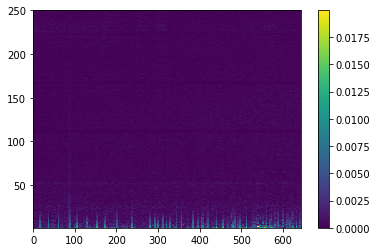

In [8]:
import eeg_utils

eeg = eeg_utils.get_eeg_instance(0)

f, Zxx, t = eeg_utils.stft(eeg, channel=0, window_size=4)

amplitude = np.max(Zxx)

im = plt.pcolormesh(t, f, abs(Zxx), vmin=0, vmax=amplitude)

plt.colorbar(im)
plt.show()

### Let us mutate the frequencies to predefined frequency bands

In [9]:
Zxx = eeg_utils.mutate_stft_to_bands(Zxx, f, t)

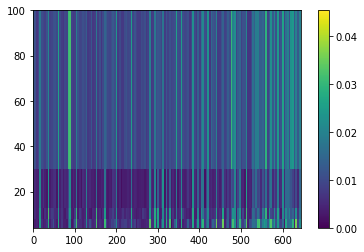

In [10]:
amplitude = np.max(Zxx)

f = np.array(list(eeg_utils.frequency_bands.values()))[:,1]

im = plt.pcolormesh(t, f, abs(Zxx), vmin=0, vmax=amplitude)

plt.colorbar(im)
plt.show()

##### Normalize frequency intensity for each band so the plot does not look odd

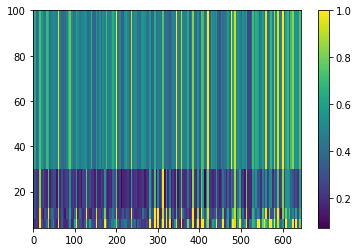

In [11]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

min_max_scaler = MaxAbsScaler()
#min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
Zxx_scaled = min_max_scaler.fit_transform(Zxx)

max_amplitude = np.max(Zxx_scaled)
min_amplitude = np.min(Zxx_scaled)

f = np.array(list(eeg_utils.frequency_bands.values()))[:,1]

im = plt.pcolormesh(t, f, abs(Zxx_scaled), vmin=min_amplitude, vmax=max_amplitude)

plt.colorbar(im)
plt.show()

#### Instead of plotting a spectogram, let us plot each frequency band as a time series (normalized and non-normalized) and the voxel of interest by their side

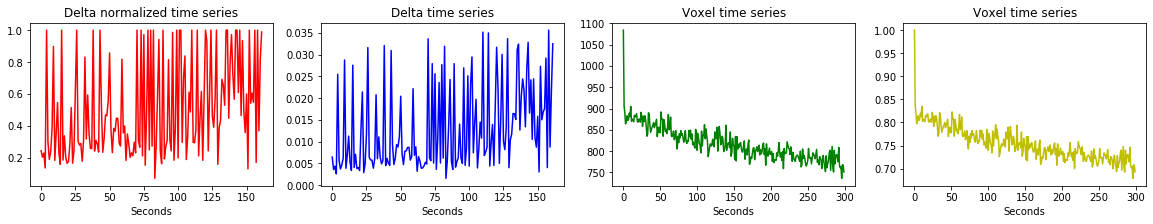

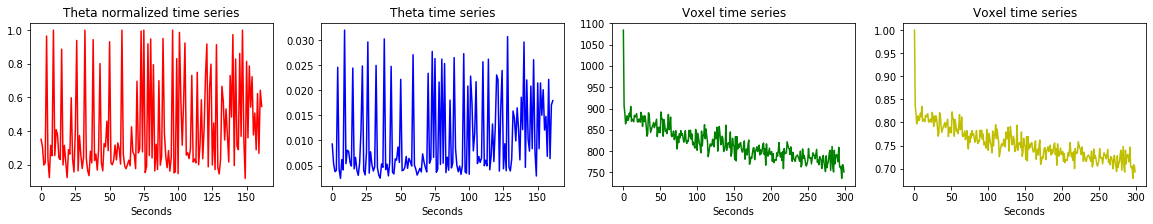

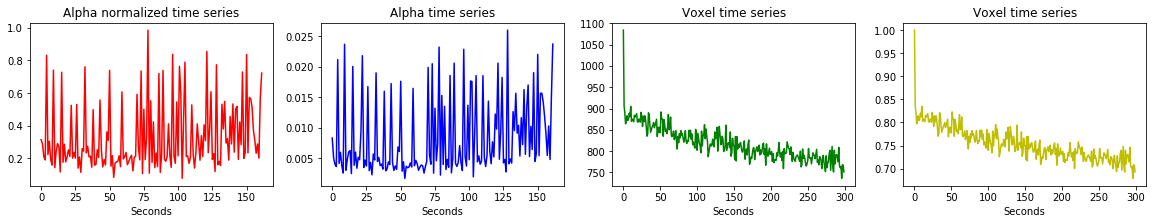

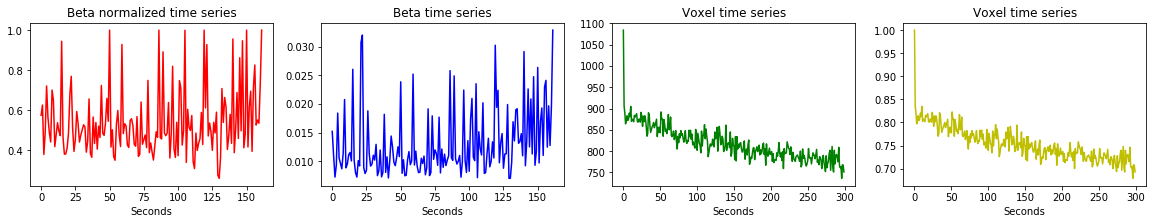

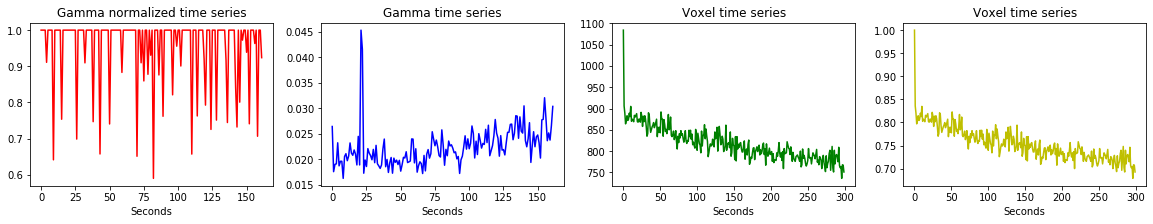

In [48]:
voxel_scaled = min_max_scaler.fit_transform(voxel.reshape(-1, 1)).reshape(voxel.shape)

for band in range(Zxx_scaled.shape[0]):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,3))
    
    ax[0].plot(Zxx_scaled[band], color='r')
    ax[0].set_title(list(eeg_utils.frequency_bands.keys())[band].capitalize() + ' normalized time series')
    ax[0].set_xlabel("Seconds")
    
    ax[1].plot(Zxx[band], color='b')
    ax[1].set_title(list(eeg_utils.frequency_bands.keys())[band].capitalize() + ' time series')
    ax[1].set_xlabel("Seconds")
    
    ax[2].plot(voxel, color='g')
    ax[2].set_title('Voxel time series')
    ax[2].set_xlabel("Seconds")
    
    ax[3].plot(voxel_scaled, color='y')
    ax[3].set_title('Voxel time series')
    ax[3].set_xlabel("Seconds")
    
    plt.show()

## Perform correlation - final goal come up with a ranking of correlations for the voxel of interest

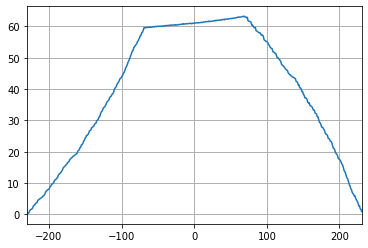

In [61]:
#reshape voxel to be 1D array
voxel = voxel.reshape((voxel.shape[0]))

correlation_coeff = correlate(Zxx_scaled[0], voxel_scaled, mode='full')

sliding = np.linspace(-len(correlation_coeff)/2, len(correlation_coeff)/2, len(correlation_coeff))
s = plt.figure()
plt.plot(sliding, correlation_coeff)
plt.grid(True, linewidth=1)
plt.axis(xmin=-len(correlation_coeff)/2, xmax=len(correlation_coeff)/2)
plt.show()

##### Rank the band of this channel with the voxel of interest

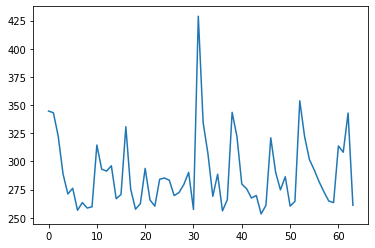

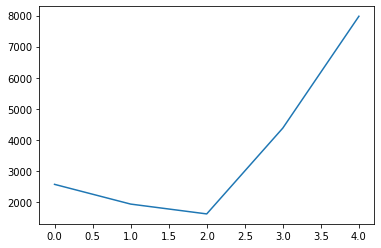

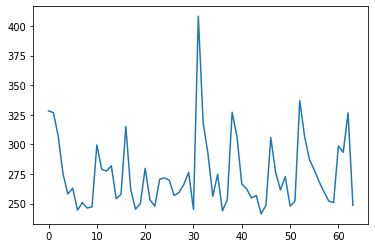

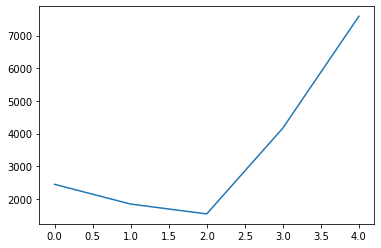

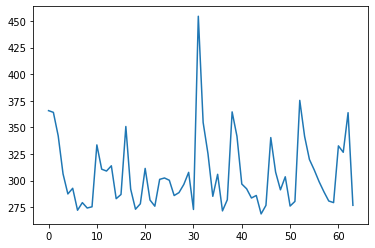

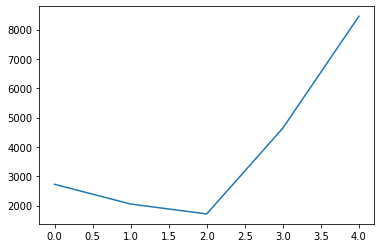

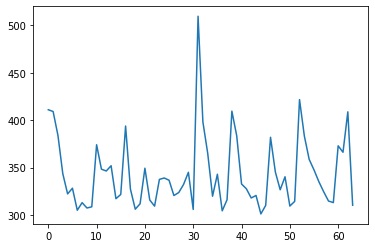

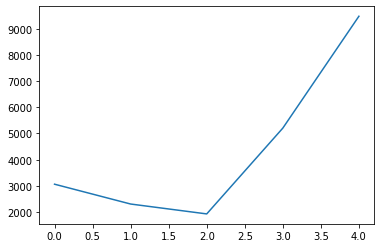

In [75]:
for voxel in [0,100,200,300]:
    voxel = fmri_utils.get_voxel(fmri_masked_instance, voxel=voxel)
    voxel_scaled = min_max_scaler.fit_transform(voxel.reshape(-1, 1)).reshape(voxel.shape)
    
    channel_correlations = []
    
    band_correlations = [0, 0, 0, 0, 0]
    
    for channel in range(len(eeg.ch_names)):
        channel_correlations += [0]

        f, Zxx, t = eeg_utils.stft(eeg, channel=channel, window_size=4)

        Zxx = eeg_utils.mutate_stft_to_bands(Zxx, f, t)
        Zxx_scaled = min_max_scaler.fit_transform(Zxx)

        for band in range(len(eeg_utils.frequency_bands)):
            correlation_coeff = correlate(Zxx_scaled[band], voxel_scaled, mode='full')
            
            band_correlations[band] += np.max(correlation_coeff)
            
            channel_correlations[-1] += np.max(correlation_coeff)
    
    plt.plot(channel_correlations)
    plt.show()

## Perform a ranking of cross correlation coefficient